In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
import ghalton

In [12]:
import scipy.special

In [3]:
import sys
sys.path.insert(1,'./code')
from get_data_res import get_data
from visualize import plot_volumes

In [4]:
list_6_4mm, list_8mm, list_10mm = get_data()

In [5]:
# Bessel Rotation
def to_radian(theta):
    return theta*np.pi/180.

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image
def bessel_rotate(image, theta, mask = False):
    t0 = time.time()
    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    #image = np.fft.fft2(image)
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                Bess = np.zeros(R.shape)
                Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
                Bess[mask_R] = 0.5
                tmp = image*Bess
                Ib[i+s,j+s] = np.sum(tmp)*np.pi/2
    if(mask):
        Ib = circle_mask(Ib)
    t1 = time.time()
    return Ib

def bessel_rotate_halton(image, theta, x1, y1, mask = False):
    t0 = time.time()
    Ib = []
    theta = to_radian(theta)
    s = (image.shape[0]-1)/2.
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    x = []
    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x.append(np.dot(rM, np.array([i,j])))
    x = np.array(x)
    for idx in xrange(len(x1)):
        R = np.sqrt((x[:,1]-x1[idx])**2 + (x[:,0]-y1[idx])**2)
        mask_R = (R == 0)
        Bess = np.zeros(R.shape)
        Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
        Bess[mask_R] = 0.5
        #Bess = Bess/(2*np.pi*np.sum(Bess*R))
        tmp = image.ravel()*Bess
        Ib.append(np.sum(tmp)*np.pi/2)
    if(mask):
        Ib = circle_mask(Ib)
    t1 = time.time()
    return np.array(Ib)

In [218]:
N = 1000
sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
sequencer.reset()
points = sequencer.get(N)
pts = np.array(points)
x1 = (len(im1)-1) * pts[:,0] - s
y1 = (len(im1)-1) * pts[:,1] - s

In [14]:
def cf_ssd(J, I):
    return np.sum((J-I)**2)
def cf_L2(J, I):
    return np.linalg.norm(J-I)
def cf_L1(J, I):
    L1 = np.reshape((J-I), [1,-1])
    return np.max(L1)

def rot_halton_cost_func(vol1, vol2, N, thetas, axis, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(thetas),3])
    # generate Halton sample points
    s = (len(vol1)-1)/2.
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = (len(vol1)-1) * pts[:,0] - s
    y1 = (len(vol1)-1) * pts[:,1] - s
    new_vol1 = np.zeros([len(vol1),N])
    for i in xrange(len(vol1)):
        if(axis == 0):
            sub1 = vol1[i,:,:]
        elif(axis == 1):
            sub1 = vol1[:,i,:]
        else:
            sub1 = vol1[:,:,i]
        rot = bessel_rotate_halton(sub1, 0, x1, y1)
        new_vol1[i] = rot
    for idx, t in enumerate(thetas):
        print t, 
        new_vol2 = np.empty([len(vol2),N])
        for i in xrange(len(vol2)):
            if(axis==0):
                sub2 = vol2[i,:,:]
            elif(axis==1):
                sub2 = vol2[:,i,:]
            else:
                sub2 = vol2[:,:,i]
            rot = bessel_rotate_halton(sub2, t, x1, y1, mask)
            new_vol2[i] = rot
        cost_func[idx,0] = cf_ssd(new_vol2,new_vol1)
        cost_func[idx,1] = cf_L1(new_vol2,new_vol1)
        cost_func[idx,2] = cf_L2(new_vol2,new_vol1)
    return cost_func

def rot_cost_func(vol1, vol2, thetas, ax, mask=False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(thetas),3])
    for idx, t in enumerate(thetas):
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(len(vol2)):
            if(axis == 0):
                sub = vol2[i,:,:]
            elif(axis == 1):
                sub = vol2[:,i,:]
            else:
                sub = vol2[:,:,i]
            
            rot = bessel_rotate(sub, t, mask)

            if(axis == 0):
                new_vol2[i,:,:] = rot
            elif(axis == 1):
                new_vol2[:,i,:] = rot
            else:
                new_vol2[:,:,i] = rot
        cost_func[idx,0] = cf_ssd(new_vol2,vol1)
        cost_func[idx,1] = cf_L1(new_vol2,vol1)
        cost_func[idx,2] = cf_L2(new_vol2,vol1)
    return cost_func

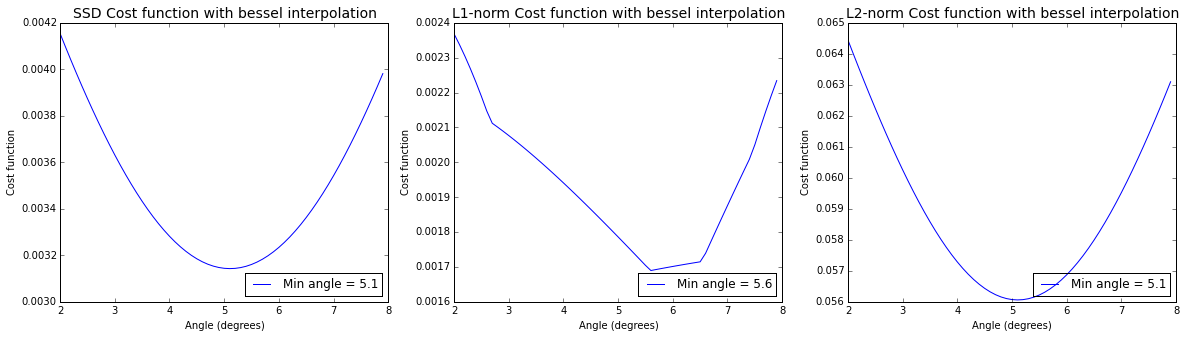

In [7]:
# Cost function from Bessel Rotation
thetas=np.arange(2,8,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(list_6_4mm[0], list_6_4mm[3], thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(list_6_4mm[0], list_6_4mm[3], thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(list_6_4mm[0], list_6_4mm[3], thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

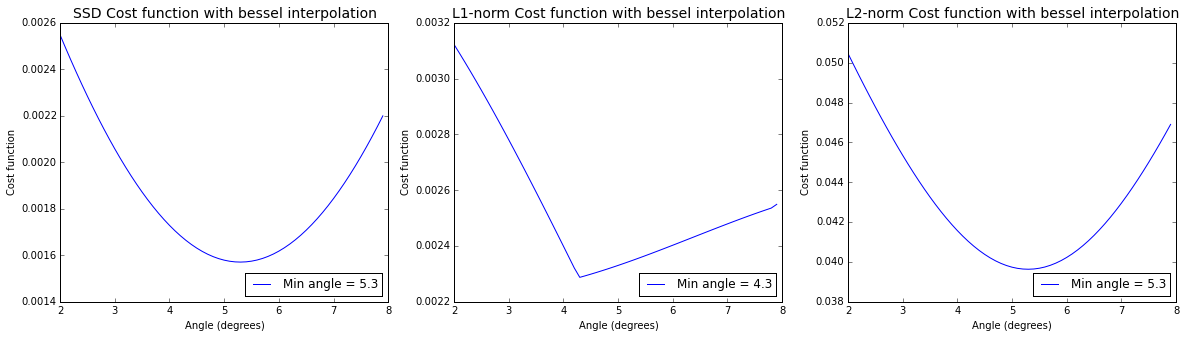

In [8]:
# Cost function from Bessel Rotation
thetas=np.arange(2,8,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(list_8mm[0], list_8mm[3], thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(list_8mm[0], list_8mm[3], thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(list_8mm[0], list_8mm[3], thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

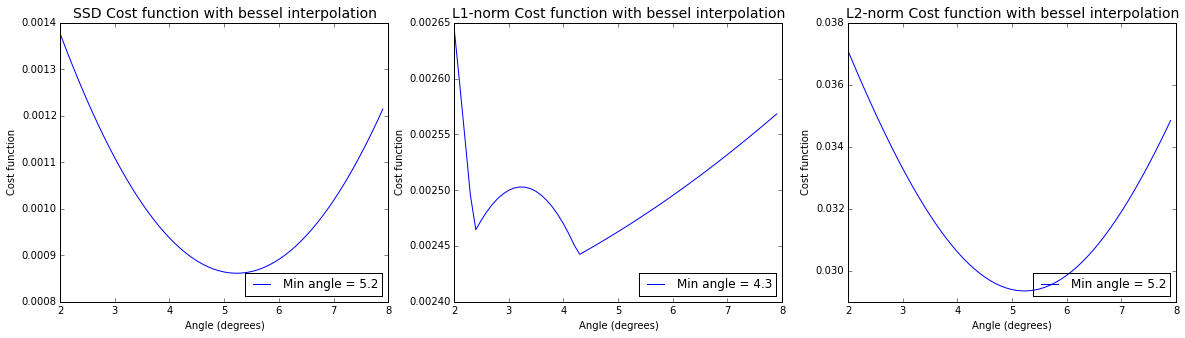

In [9]:
# Cost function from Bessel Rotation
thetas=np.arange(2,8,0.1)
# With circular mask
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(5)
rot_cost_func(list_10mm[0], list_10mm[3], thetas, cf_ssd, 'SSD',ax[0], 'bessel', True)
rot_cost_func(list_10mm[0], list_10mm[3], thetas, cf_L1, 'L1-norm',ax[1], 'bessel', True)
rot_cost_func(list_10mm[0], list_10mm[3], thetas, cf_L2, 'L2-norm',ax[2], 'bessel', True)
plt.show()
plt.close(fig)

In [17]:
def plot_cost_func(cost_func,res):
    fig, ax = plt.subplots(1,3)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    arg = ['SSD', 'L1', 'L2']
    angMin = thetas[np.argmin(cost_func,axis=0)]
    for i in xrange(3):
        ax[i].plot(thetas,cost_func[:,i],label='Min angle = %s\n Resolution = %smm' % (angMin[i], res))
        ax[i].set_title('%s Cost function with bessel interpolation' % arg[i], fontsize=14)
        ax[i].set_xlabel('Angle (degrees)')
        ax[i].set_ylabel('Cost function')
        ax[i].legend(loc=4)
    plt.show()
    plt.close(fig)

#Bessel Interpolation with Halton Sampling

### Rotation Along Axis 0

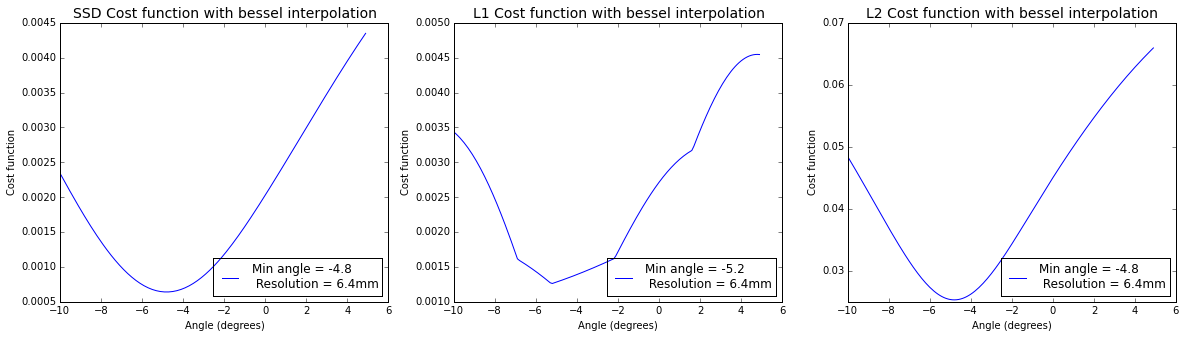

In [202]:
# Resolution 6.4, rotation along axis 0
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,6.4)

In [18]:
# Resolution 6.4, rotation along axis 0 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[3], N, thetas, 0, False)

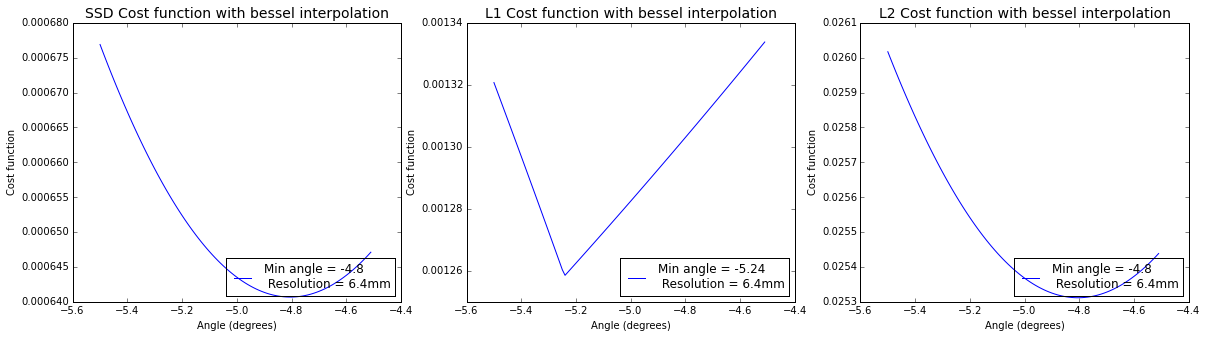

In [19]:
plot_cost_func(cost_func,6.4)

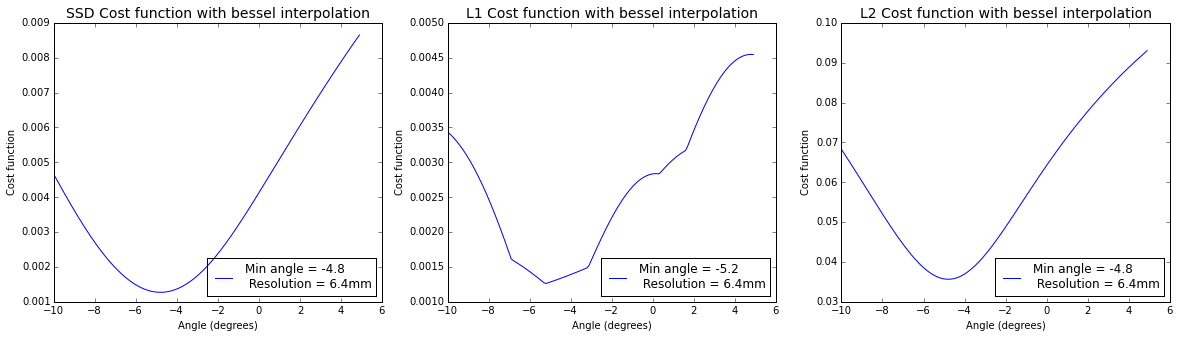

In [233]:
# Resolution 6.4, rotation along axis 0
N = 2000
# Cost function from Bessel Rotation
thetas = np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,6.4)

In [21]:
# Resolution 6.4, rotation along axis 0 with 0.01 increment
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[3], N, thetas, 0, False)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51


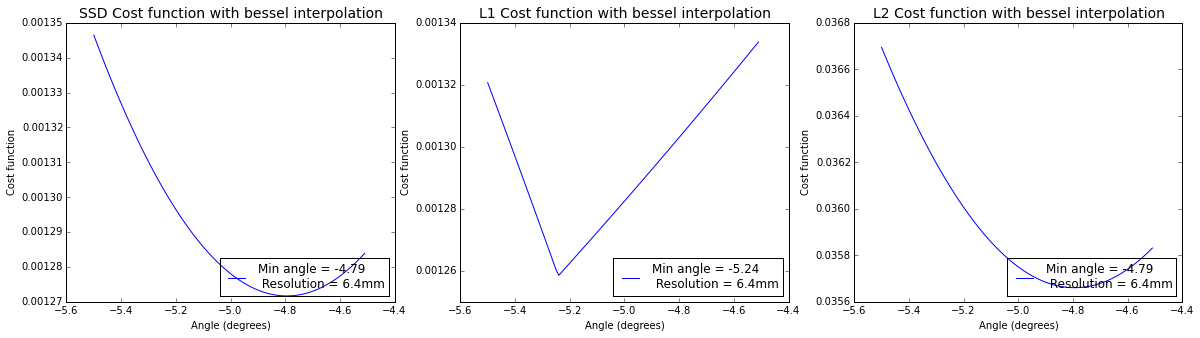

In [23]:
plot_cost_func(cost_func,6.4)

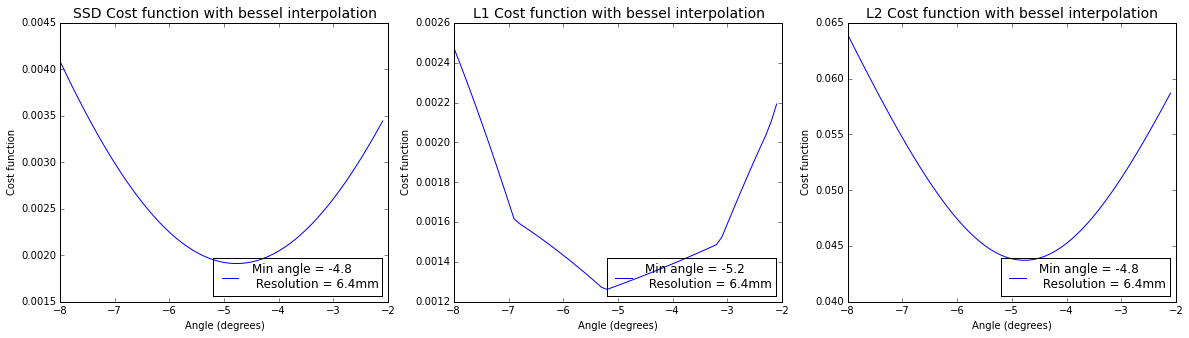

In [249]:
# Resolution 6.4, rotation along axis 0
N = 3000
# Cost function from Bessel Rotation
thetas = np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,6.4)

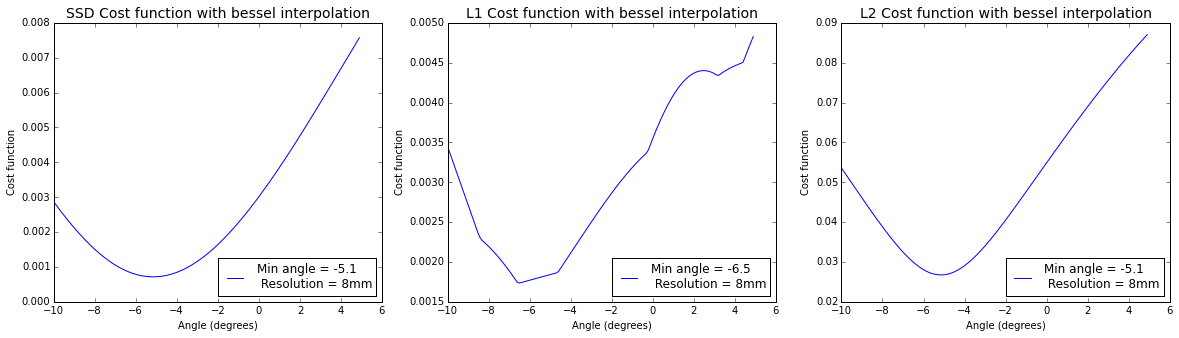

In [203]:
# Resolution 8, rotation along axis 0
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,8)

In [24]:
# Resolution 8, rotation along axis 0, with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas = np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[3], N, thetas, 0, False)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51


In [25]:
pickle.dump(cost_func,open('cost_func_1000_0_01_8mm_axis0.p','wb'))

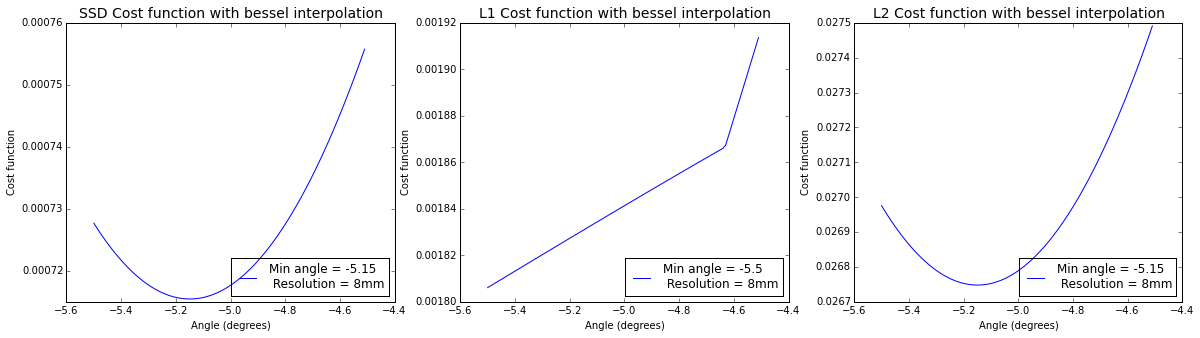

In [26]:
plot_cost_func(cost_func,8)

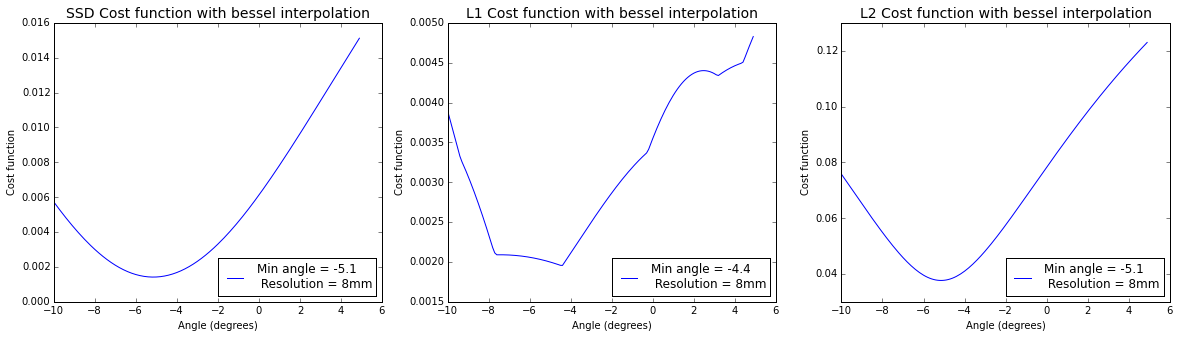

In [234]:
# Resolution 8, rotation along axis 0
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,8)

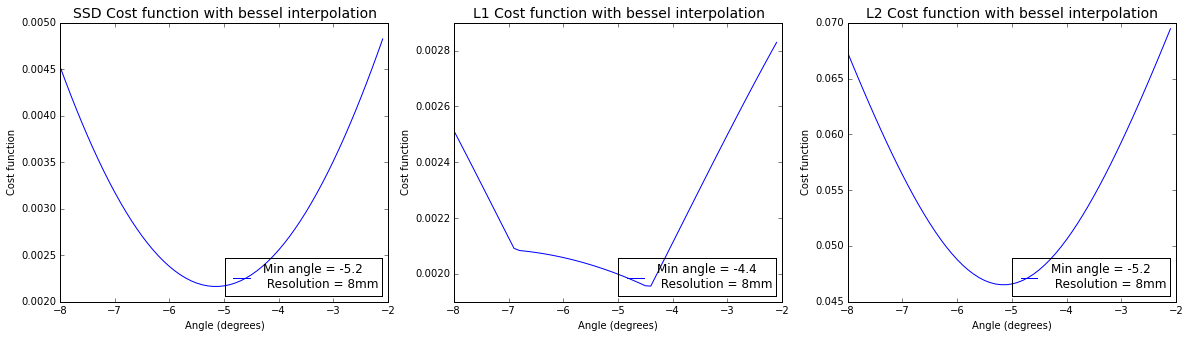

In [250]:
# Resolution 8, rotation along axis 0
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,8)

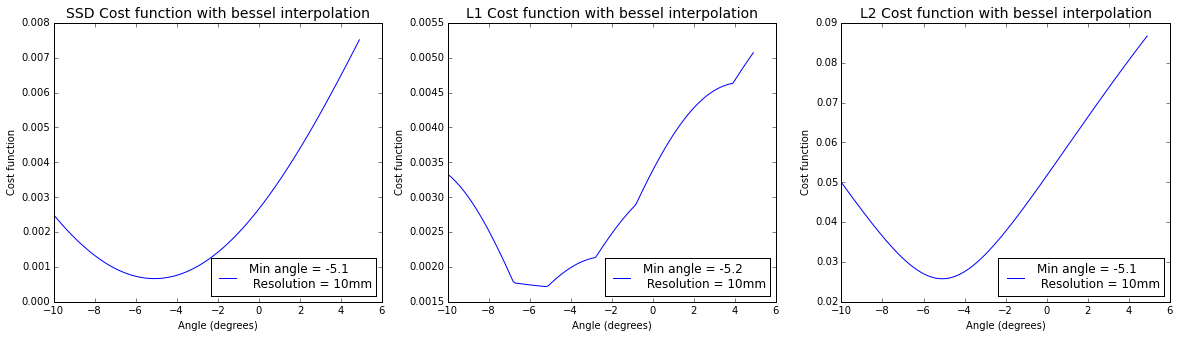

In [204]:
# Resolution 10, rotation along axis 0
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,10)

In [27]:
# Resolution 10, rotation along axis 0, with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[3], N, thetas, 0, False)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51


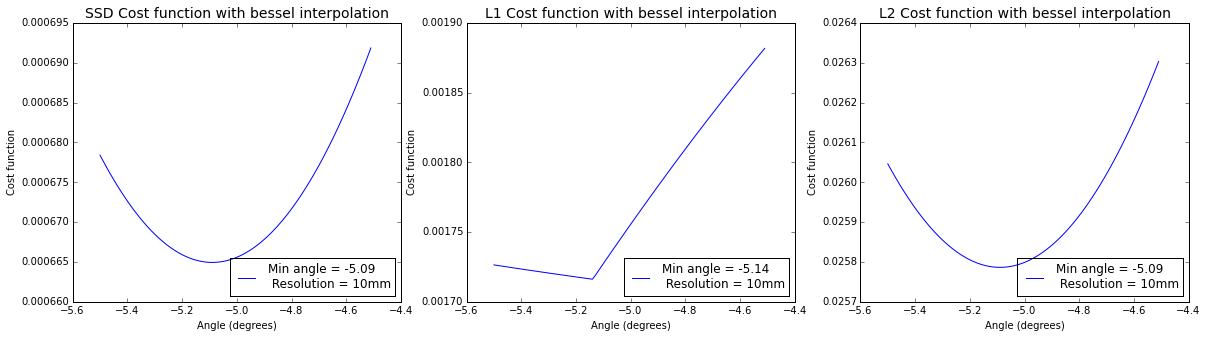

In [29]:
plot_cost_func(cost_func,10)

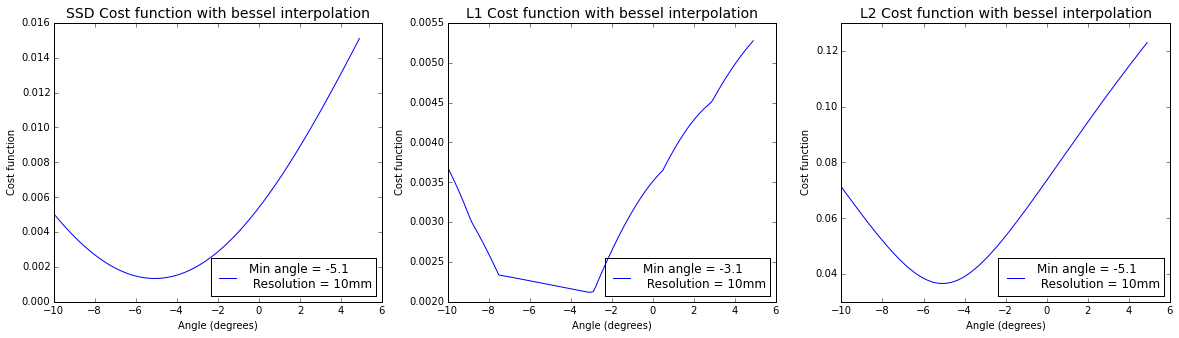

In [235]:
# Resolution 10, rotation along axis 0
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,10)

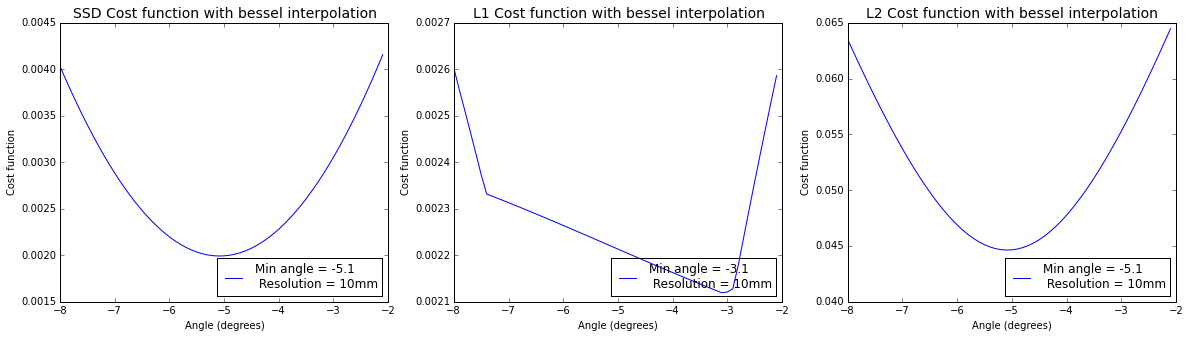

In [251]:
# Resolution 10, rotation along axis 0
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[3], N, thetas, 0, False)
plot_cost_func(cost_func,10)

### Rotation Along Axis 1

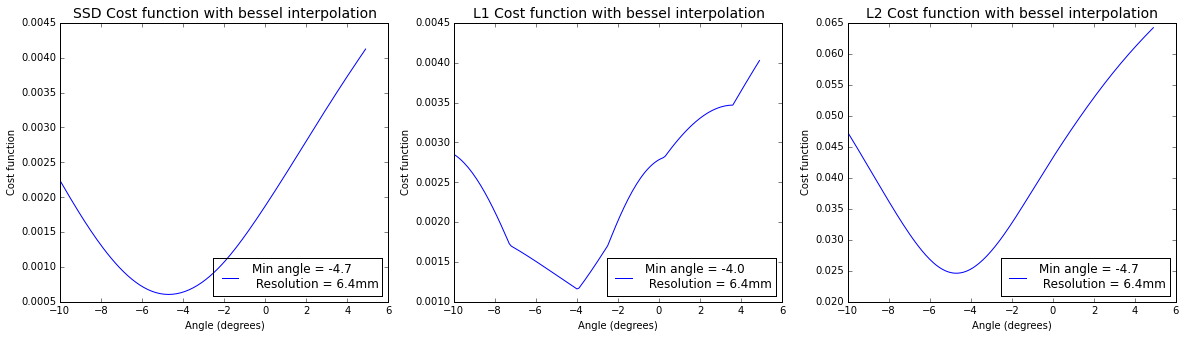

In [206]:
# Resolution 6.4, rotation along axis 1
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,6.4)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51

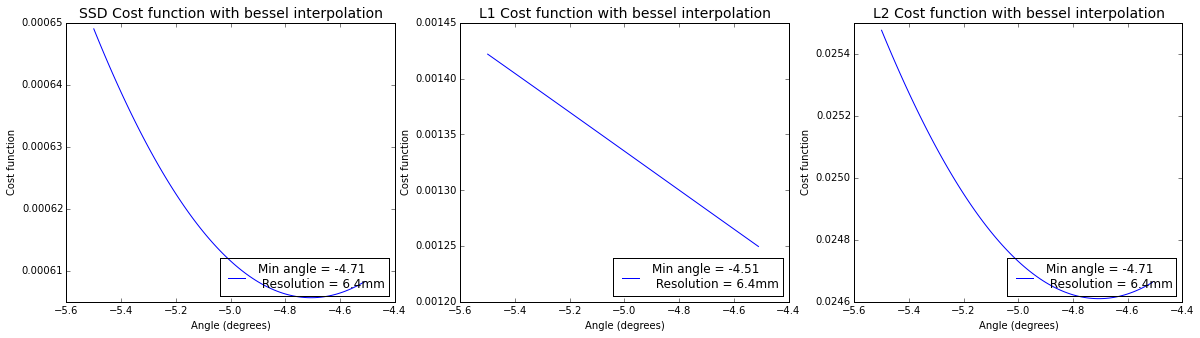

In [41]:
# Resolution 6.4, rotation along axis 1 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,6.4)

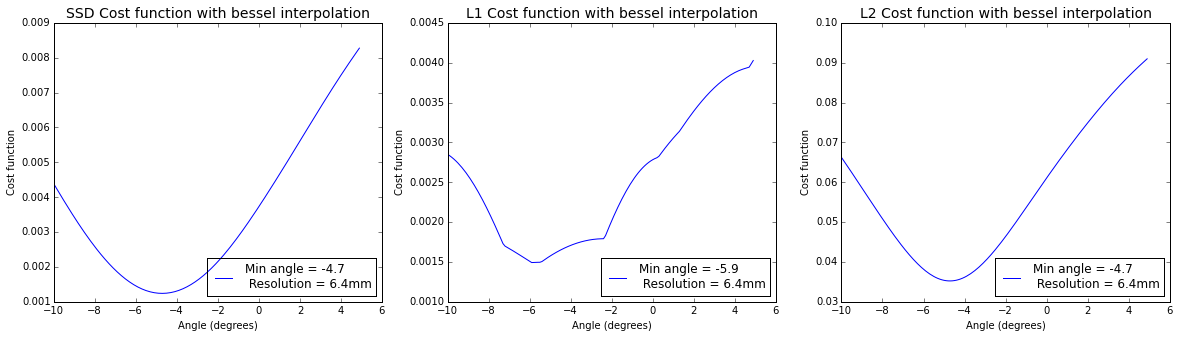

In [236]:
# Resolution 6.4, rotation along axis 1
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,6.4)

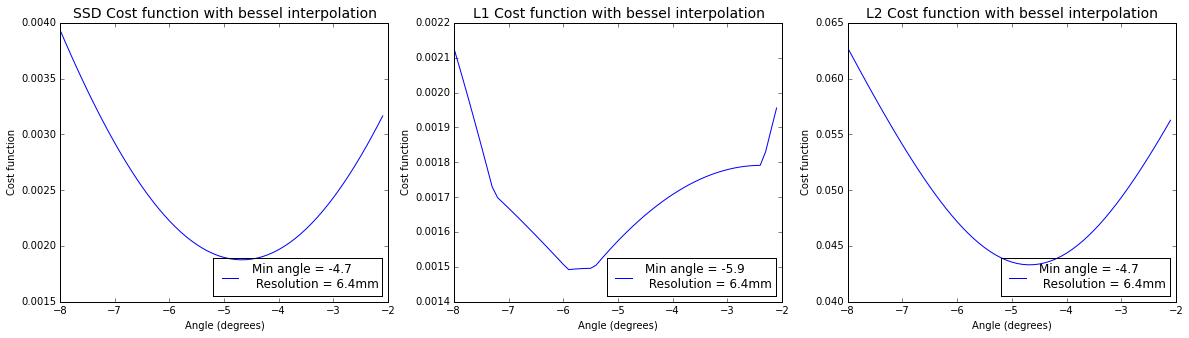

In [243]:
# Resolution 6.4, rotation along axis 1
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,6.4)

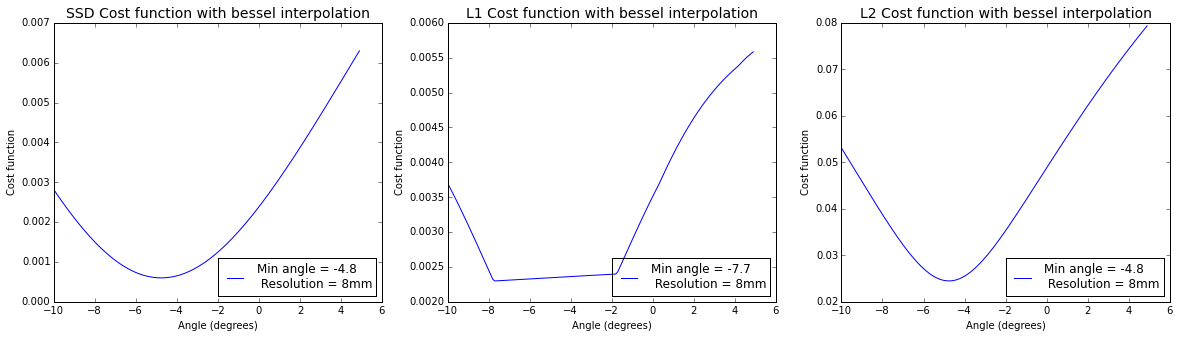

In [207]:
# Resolution 8, rotation along axis 1
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,8)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51

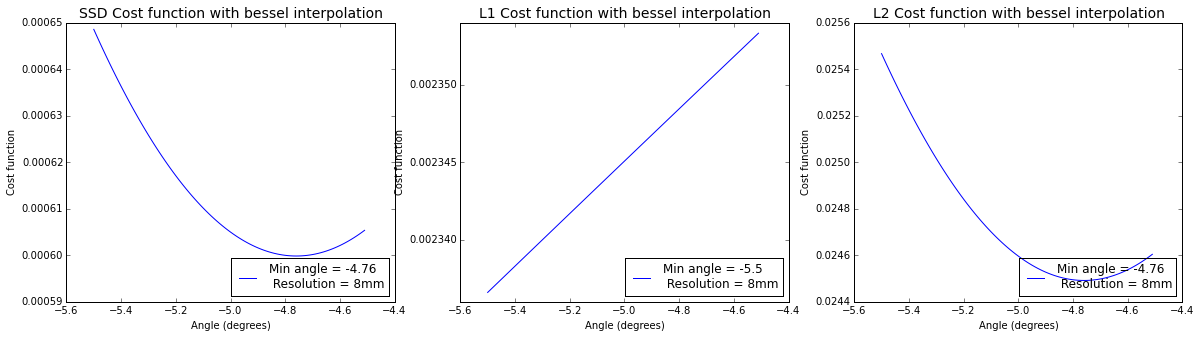

In [42]:
# Resolution 8, rotation along axis 1 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,8)

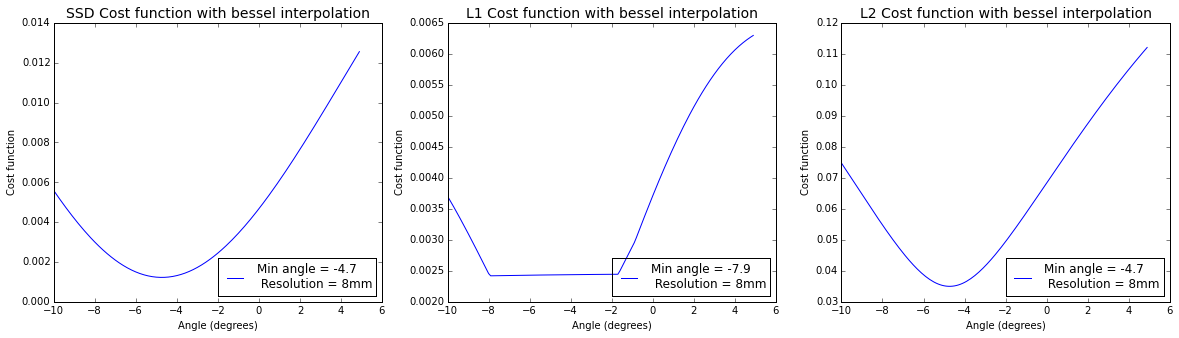

In [237]:
# Resolution 8, rotation along axis 1
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,8)

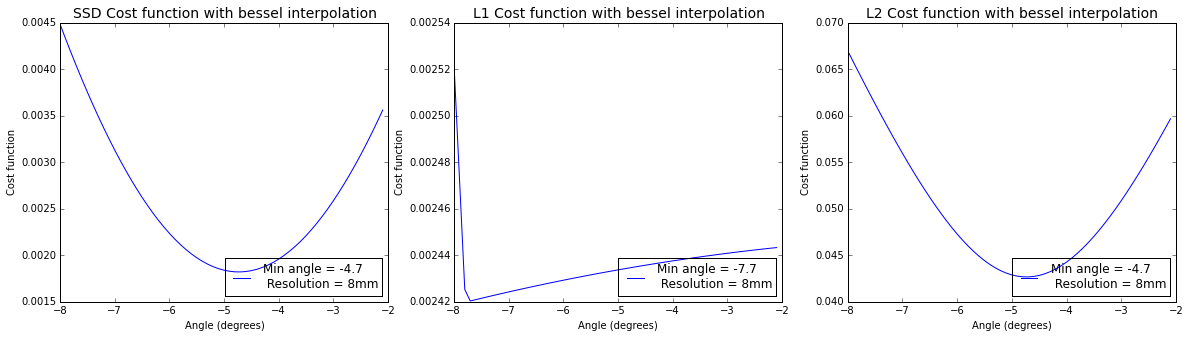

In [244]:
# Resolution 8, rotation along axis 1
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,8)

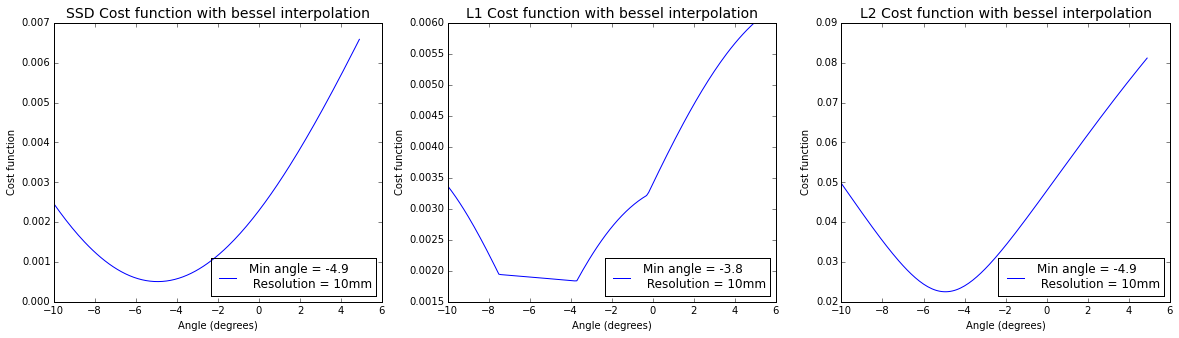

In [208]:
# Resolution 10, rotation along axis 1
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,10)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51

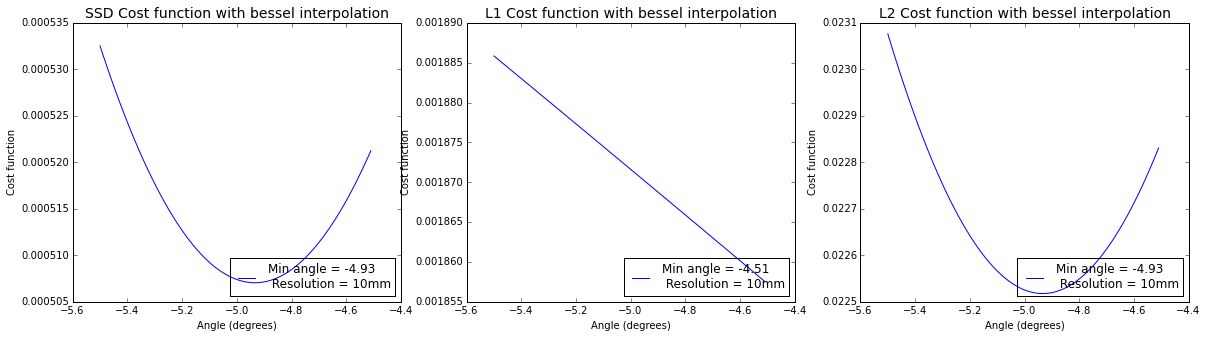

In [32]:
# Resolution 10, rotation along axis 1 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,10)

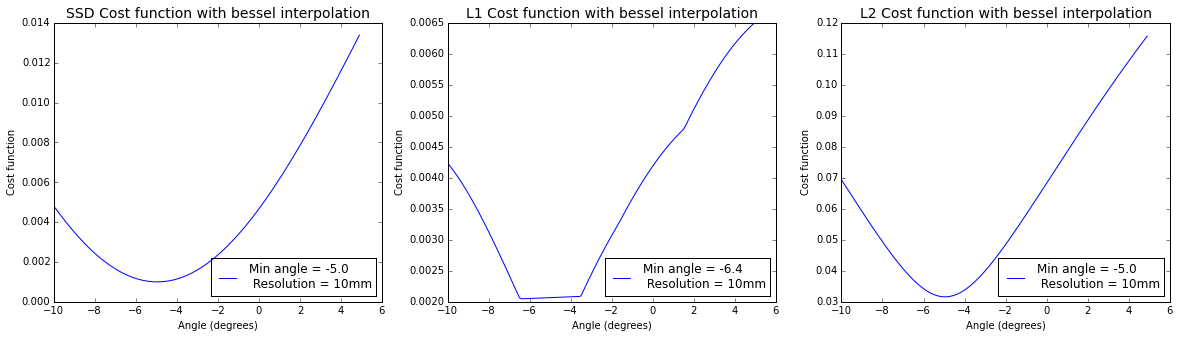

In [238]:
# Resolution 10, rotation along axis 1
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
        cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,10)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51

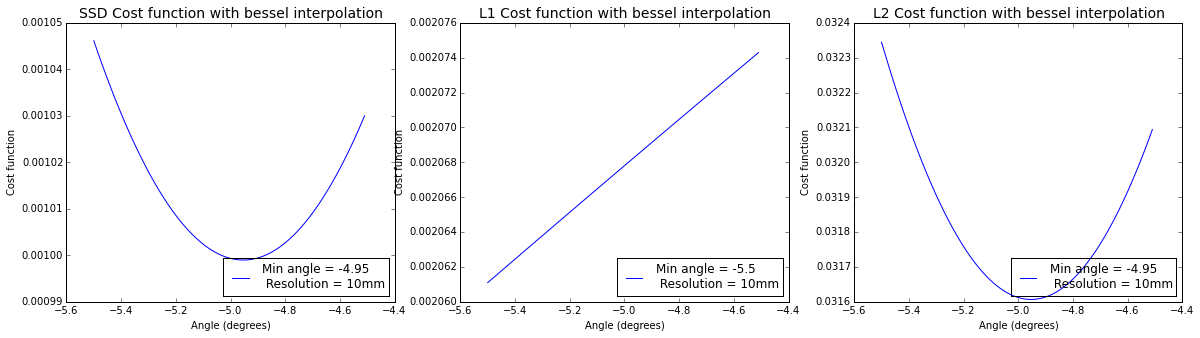

In [33]:
# Resolution 10, rotation along axis 1 with 0.01 increment
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,10)

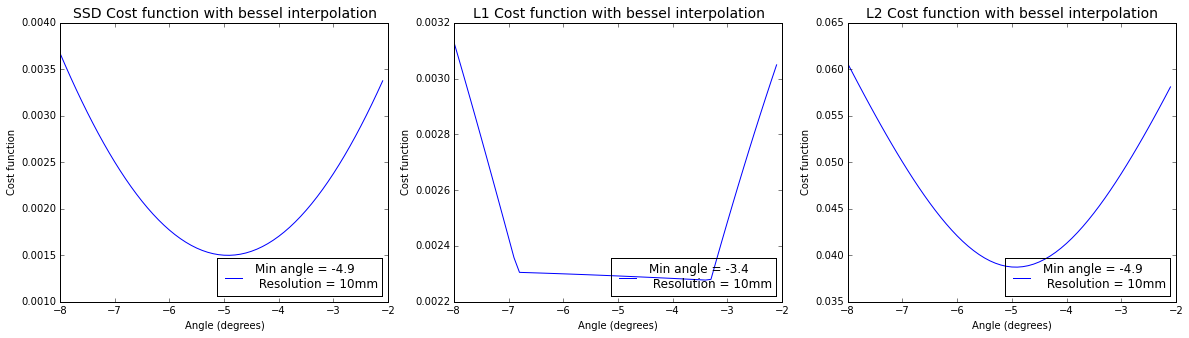

In [245]:
# Resolution 10, rotation along axis 1
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,10)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51

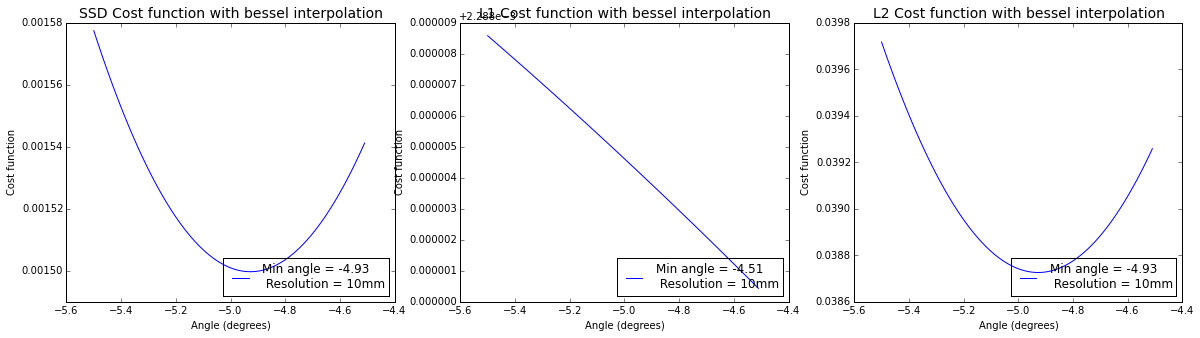

In [34]:
# Resolution 10, rotation along axis 1 with 0.01 increment
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.5,0.01)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[1], N, thetas, 1, False)
plot_cost_func(cost_func,10)

### Rotation Along Axis 2

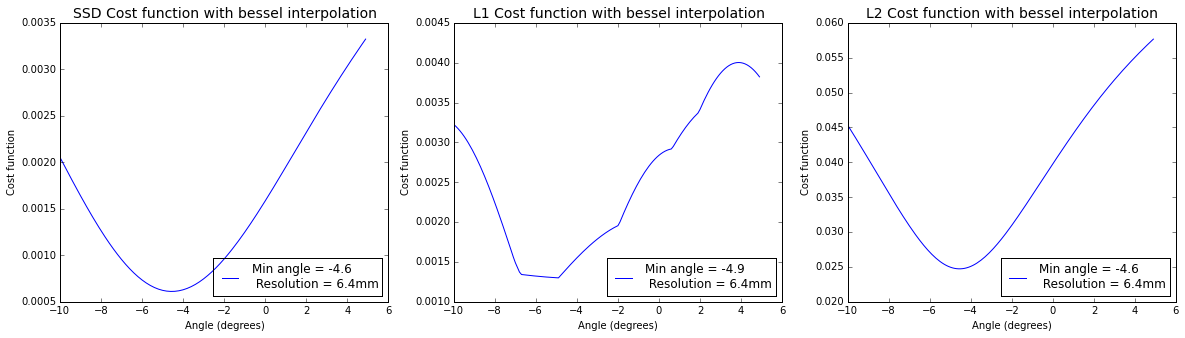

In [209]:
# Resolution 6.4, rotation along axis 2
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,6.4)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51 -4.5 -4.49 -4.48 -4.47 -4.46 -4.45 -4.44 -4.43 -4.42 -4.41 -4.4 -4.39 -4.38 -4.37 -4.36 -4.35 -4.34 -4.33 -4.32 -4.31 -4.3 -4.29 -4.28 -4.27 -4.26 -4.25 -4.24 -4.23 -4.22 -4.21 -4.2 -4.19 -4.18 -4.17 -4.16 -4.15 -4.14 -4.13 -4.12 -4.11 -4.1 -4.09 -4.08 -4.07 -4.06 -4.05 -4.04 -4.03 -4.02 -4.01

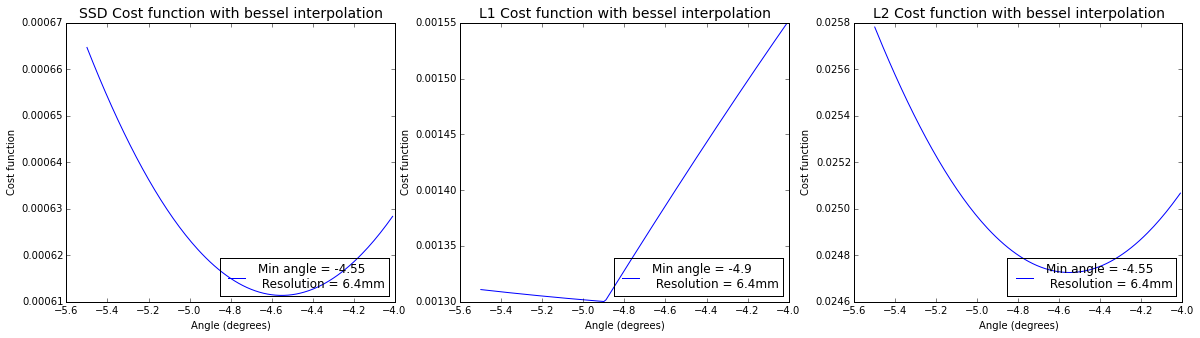

In [43]:
 # Resolution 6.4, rotation along axis 2 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.0,0.01)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,6.4)

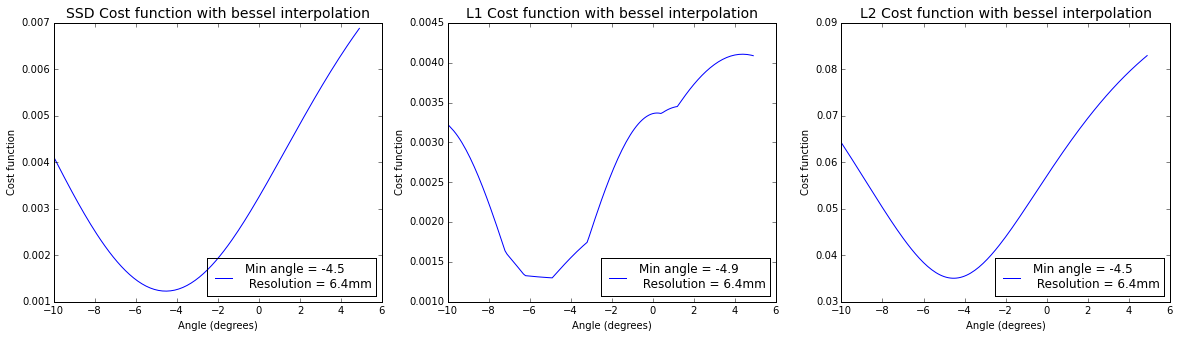

In [239]:
# Resolution 6.4, rotation along axis 2
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,6.4)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51 -4.5 -4.49 -4.48 -4.47 -4.46 -4.45 -4.44 -4.43 -4.42 -4.41 -4.4 -4.39 -4.38 -4.37 -4.36 -4.35 -4.34 -4.33 -4.32 -4.31 -4.3 -4.29 -4.28 -4.27 -4.26 -4.25 -4.24 -4.23 -4.22 -4.21 -4.2 -4.19 -4.18 -4.17 -4.16 -4.15 -4.14 -4.13 -4.12 -4.11 -4.1 -4.09 -4.08 -4.07 -4.06 -4.05 -4.04 -4.03 -4.02 -4.01

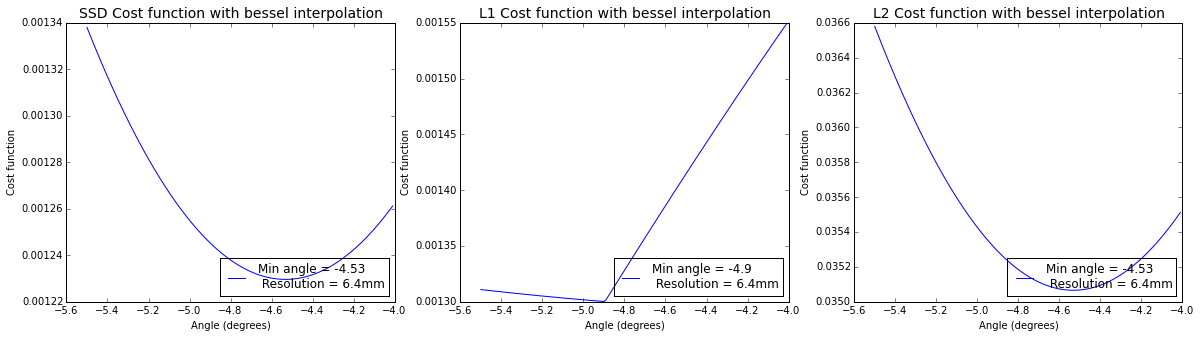

In [44]:
 # Resolution 6.4, rotation along axis 2 with 0.01 increment
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.0,0.01)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,6.4)

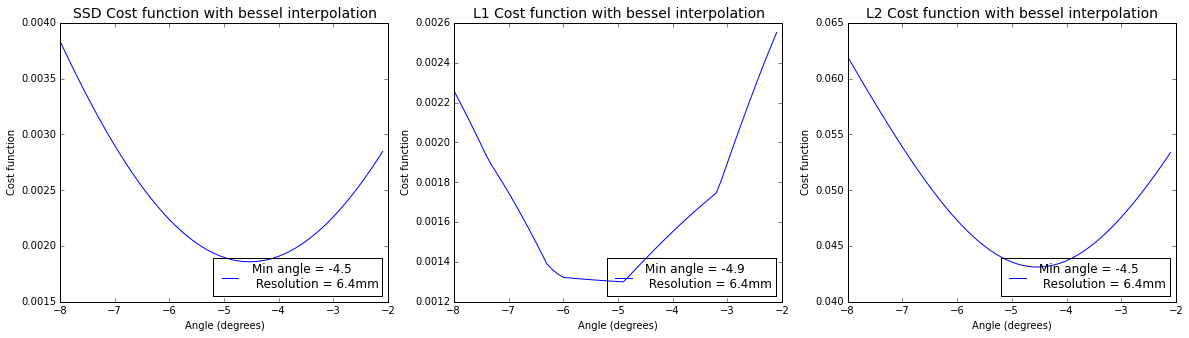

In [246]:
# Resolution 6.4, rotation along axis 2
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,6.4)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51 -4.5 -4.49 -4.48 -4.47 -4.46 -4.45 -4.44 -4.43 -4.42 -4.41 -4.4 -4.39 -4.38 -4.37 -4.36 -4.35 -4.34 -4.33 -4.32 -4.31 -4.3 -4.29 -4.28 -4.27 -4.26 -4.25 -4.24 -4.23 -4.22 -4.21 -4.2 -4.19 -4.18 -4.17 -4.16 -4.15 -4.14 -4.13 -4.12 -4.11 -4.1 -4.09 -4.08 -4.07 -4.06 -4.05 -4.04 -4.03 -4.02 -4.01

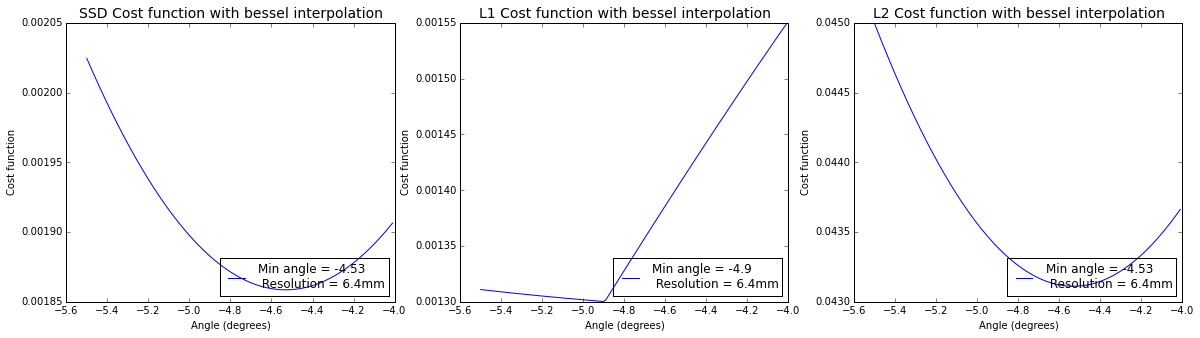

In [45]:
 # Resolution 6.4, rotation along axis 2 with 0.01 increment
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.0,0.01)
cost_func = rot_halton_cost_func(list_6_4mm[0], list_6_4mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,6.4)

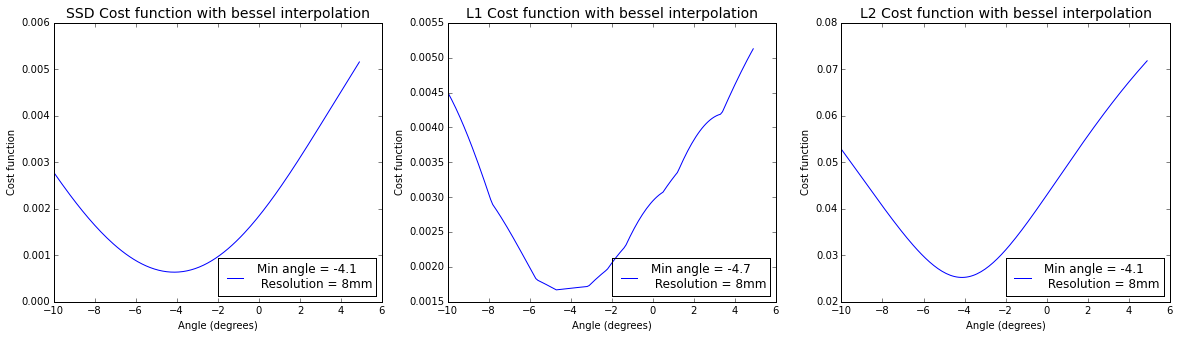

In [210]:
# Resolution 8, rotation along axis 2
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,8)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51 -4.5 -4.49 -4.48 -4.47 -4.46 -4.45 -4.44 -4.43 -4.42 -4.41 -4.4 -4.39 -4.38 -4.37 -4.36 -4.35 -4.34 -4.33 -4.32 -4.31 -4.3 -4.29 -4.28 -4.27 -4.26 -4.25 -4.24 -4.23 -4.22 -4.21 -4.2 -4.19 -4.18 -4.17 -4.16 -4.15 -4.14 -4.13 -4.12 -4.11 -4.1 -4.09 -4.08 -4.07 -4.06 -4.05 -4.04 -4.03 -4.02 -4.01

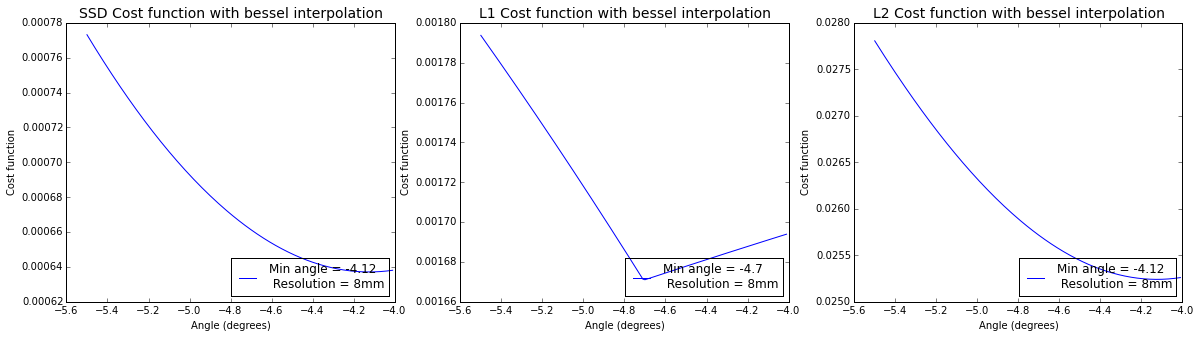

In [46]:
 # Resolution 8, rotation along axis 2 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.0,0.01)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,8)

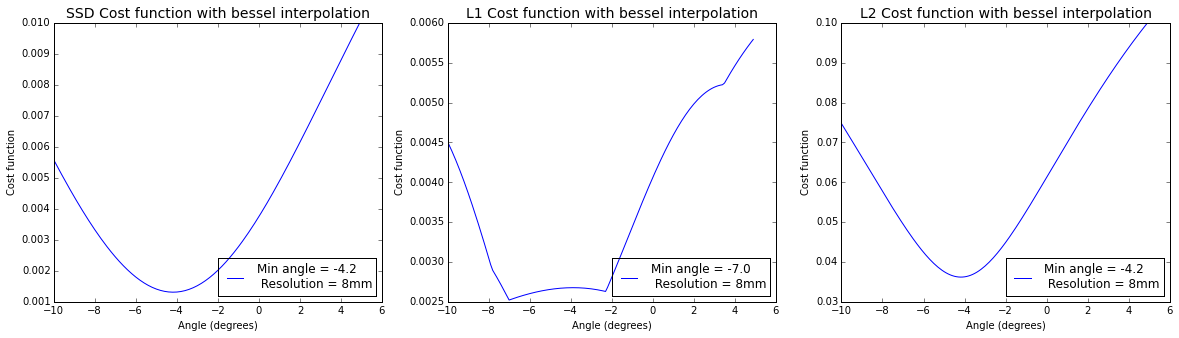

In [240]:
# Resolution 8, rotation along axis 2
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,8)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51 -4.5 -4.49 -4.48 -4.47 -4.46 -4.45 -4.44 -4.43 -4.42 -4.41 -4.4 -4.39 -4.38 -4.37 -4.36 -4.35 -4.34 -4.33 -4.32 -4.31 -4.3 -4.29 -4.28 -4.27 -4.26 -4.25 -4.24 -4.23 -4.22 -4.21 -4.2 -4.19 -4.18 -4.17 -4.16 -4.15 -4.14 -4.13 -4.12 -4.11 -4.1 -4.09 -4.08 -4.07 -4.06 -4.05 -4.04 -4.03 -4.02 -4.01

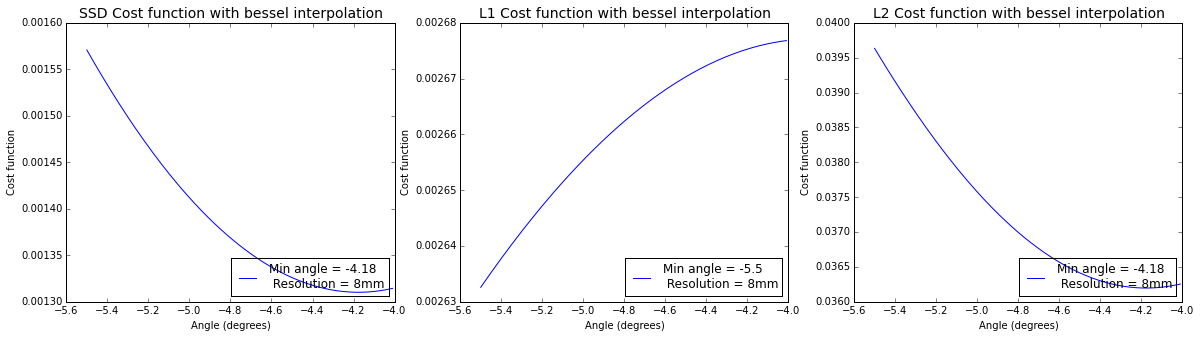

In [47]:
 # Resolution 8, rotation along axis 2 with 0.01 increment
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.0,0.01)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,8)

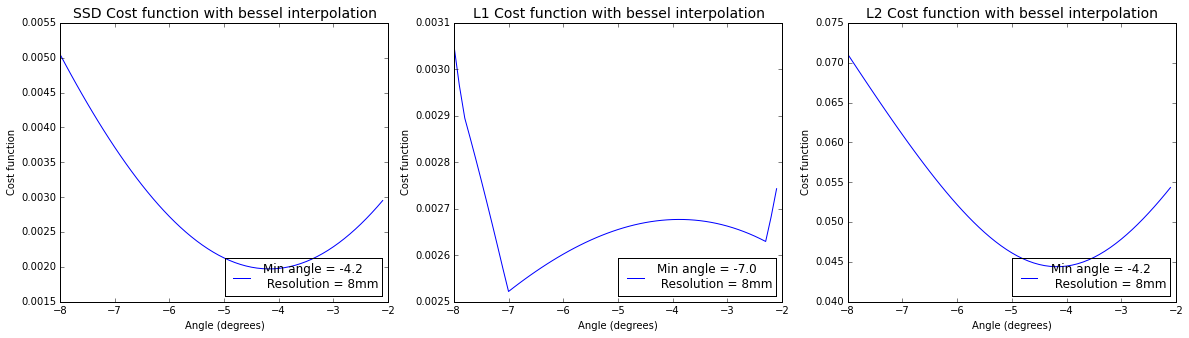

In [247]:
# Resolution 8, rotation along axis 2
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_8mm[0], list_8mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,8)

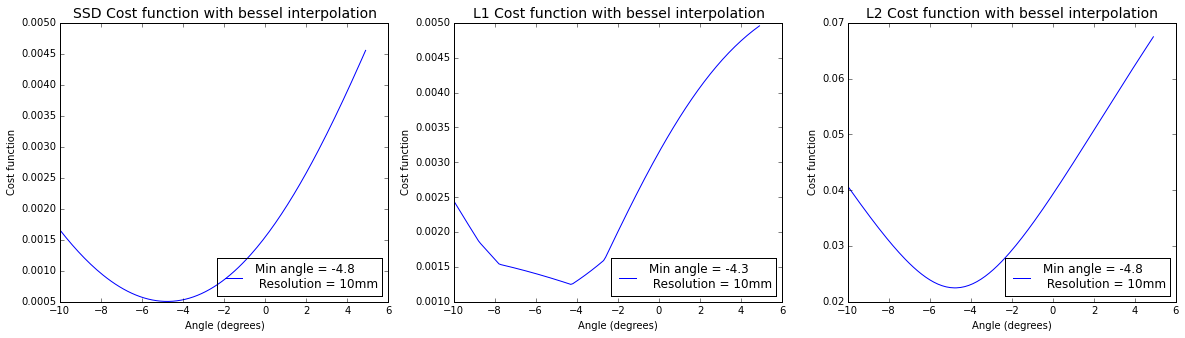

In [211]:
# Resolution 10, rotation along axis 2
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,10)

-5.5 -5.49 -5.48 -5.47 -5.46 -5.45 -5.44 -5.43 -5.42 -5.41 -5.4 -5.39 -5.38 -5.37 -5.36 -5.35 -5.34 -5.33 -5.32 -5.31 -5.3 -5.29 -5.28 -5.27 -5.26 -5.25 -5.24 -5.23 -5.22 -5.21 -5.2 -5.19 -5.18 -5.17 -5.16 -5.15 -5.14 -5.13 -5.12 -5.11 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6 -4.59 -4.58 -4.57 -4.56 -4.55 -4.54 -4.53 -4.52 -4.51 -4.5 -4.49 -4.48 -4.47 -4.46 -4.45 -4.44 -4.43 -4.42 -4.41 -4.4 -4.39 -4.38 -4.37 -4.36 -4.35 -4.34 -4.33 -4.32 -4.31 -4.3 -4.29 -4.28 -4.27 -4.26 -4.25 -4.24 -4.23 -4.22 -4.21 -4.2 -4.19 -4.18 -4.17 -4.16 -4.15 -4.14 -4.13 -4.12 -4.11 -4.1 -4.09 -4.08 -4.07 -4.06 -4.05 -4.04 -4.03 -4.02 -4.01

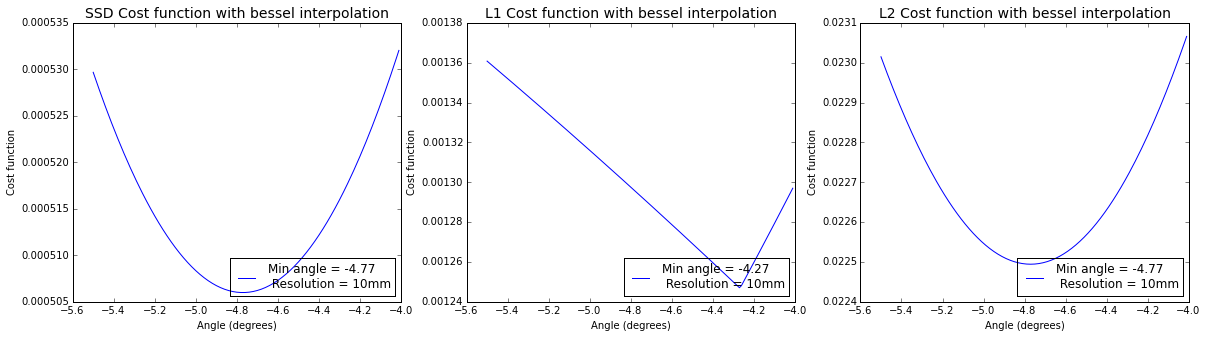

In [48]:
 # Resolution 10, rotation along axis 2 with 0.01 increment
N = 1000
# Cost function from Bessel Rotation
thetas=np.arange(-5.5,-4.0,0.01)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,10)

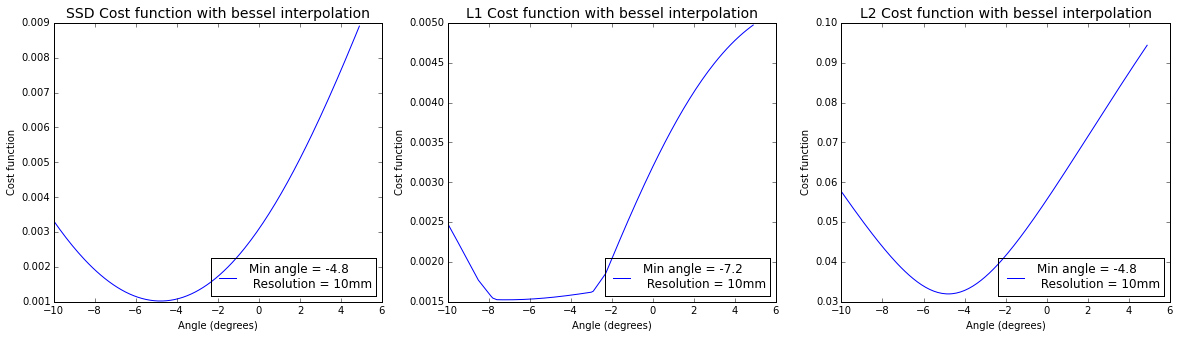

In [242]:
# Resolution 10, rotation along axis 2
N = 2000
# Cost function from Bessel Rotation
thetas=np.arange(-10,5,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,10)

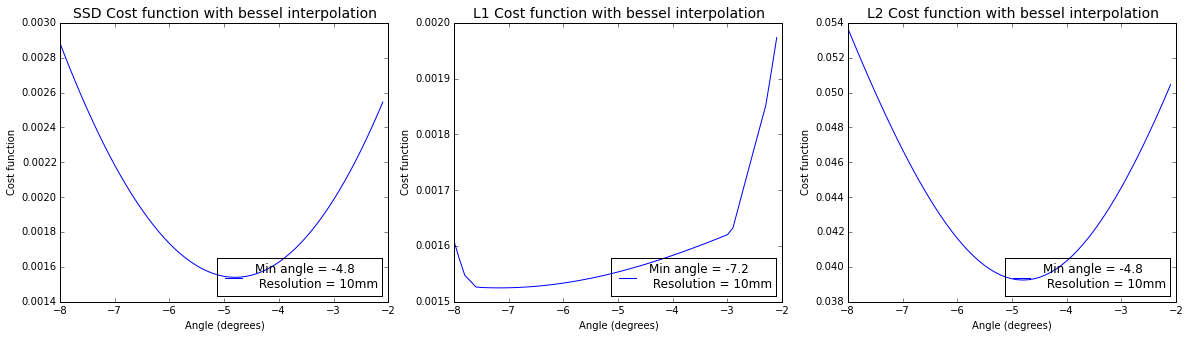

In [248]:
# Resolution 10, rotation along axis 2
N = 3000
# Cost function from Bessel Rotation
thetas=np.arange(-8,-2,0.1)
cost_func = rot_halton_cost_func(list_10mm[0], list_10mm[2], N, thetas, 2, False)
plot_cost_func(cost_func,10)